# Method 1: Using Pystan

I'll do this for a single n, and treat the mode locations as fixed for now.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
import pystan
import pickle
import os
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)
matplotlib.rcParams['text.usetex'] = False

#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [17]:
locs = np.genfromtxt('locs.txt')
mid = int(np.floor(len(locs)/2))
l0 = locs[mid, 0]
l1 = locs[mid, 1]
l2 = locs[mid-1, 2]
l3 = locs[mid-1, 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [83]:
sel = [(ff >= 2185) & (ff <= 2260)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

In [84]:
# modelocs = np.concatenate((l0, l1, l2, l3))
modelocs = np.array([l2, l0, l1])
# modeids = [0]*len(l0) + [1]*len(l1) + [2]*len(l2) + [3]*len(l3)
modeids = [2, 0, 1]

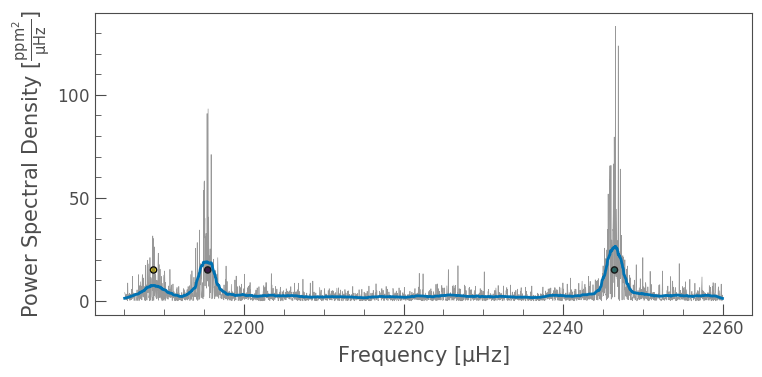

In [85]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

Lets fit a group of lorentzians to these data!

In [ ]:
overwrite = True
pbjam = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
    int asy_ids[M];   // The ID's of the modes
}
parameters{
    real logAmp[M];         // Mode amplitude in log space
    real logGamma[M];       // Mode linewidth in log space
    real locs[M];  // True mode locations
    real vsini;    // Line of sight rotational frequency
    real<lower=0.> nus;      // Rotational frequency splitting
}
transformed parameters{
    real H[M];       // Mode height
    real w[M];       // Mode linewidth
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes; // Our Model
    real i;          // Angle of inclination (rad)
    matrix[4,4] eps; // Matrix of legendre polynomials
    int l;           // The radial degree
    
    // First we'll calculate all the legendre polynomials for this i
    i = asin(vsini / nus);
    eps = rep_matrix(1., 4, 4);
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

    modes = rep_vector(1., N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = asy_ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1);
    logGamma ~ normal(0, 0.01);
    locs ~ normal(asy_locs, 1);
    nus ~ normal(0.411, 0.1);
    vsini ~ uniform(0.,nus);
}
'''
model_path = 'pbjam.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = pbjam, model_name='pbjam')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = pbjam, model_name='pbjam')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL pbjam_5d741409ec537dfd1d682563c5f5d8a3 NOW.


Updating Stan model


In [87]:
data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'asy_locs':modelocs,
        'asy_ids':modeids}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'logGamma' : np.zeros(len(modelocs)),
        'vsini':nus*np.sin(i),
        'nus':nus,
        'locs' : modelocs}

In [88]:
nchains = 4
fit = sm.sampling(data=data, iter=5000, chains=nchains, verbose=False, init = [init for n in range(nchains)])

In [89]:
print(fit)

Inference for Stan model: pbjam_02968e38a317ae352bebb66f7b6c8ebf.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]     1.76  1.1e-3   0.06   1.64   1.72   1.77   1.81   1.88   3411    1.0
logAmp[2]     2.39  7.0e-4   0.05    2.3   2.36   2.39   2.43   2.49   4525    1.0
logAmp[3]     2.69  6.5e-4   0.04   2.61   2.66   2.69   2.71   2.76   3554    1.0
logGamma[1] 5.0e-3  1.6e-4   0.01  -0.01-1.9e-3 5.0e-3   0.01   0.03   3832    1.0
logGamma[2]   0.01  1.5e-4   0.01-9.4e-3 3.6e-3   0.01   0.02   0.03   4762    1.0
logGamma[3]   0.01  1.5e-4   0.01-5.7e-3 8.1e-3   0.01   0.02   0.03   4546    1.0
locs[1]     2188.6  1.8e-3   0.12 2188.3 2188.5 2188.6 2188.6 2188.8   4474    1.0
locs[2]     2195.5  1.5e-3    0.1 2195.3 2195.4 2195.5 2195.5 2195.7   4492    1.0
locs[3]     2246.4  1.6e-3   0.11 2246.2 2246.4 2246.4 2246.5 2246.6

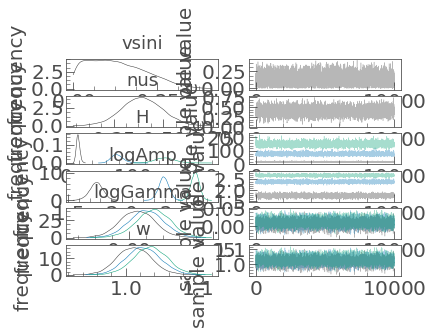

In [90]:
fit.plot(pars=['vsini','nus','H','logAmp','logGamma','w'])
plt.show()

In [91]:
truths= [init['vsini'],init['nus']]

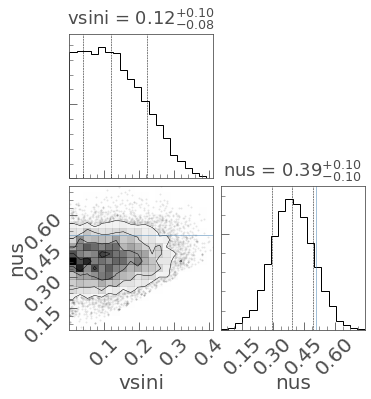

l = 2


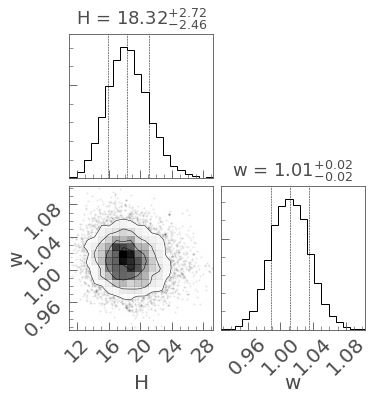

l = 0


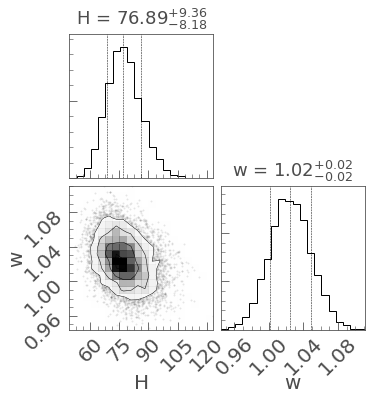

l = 1


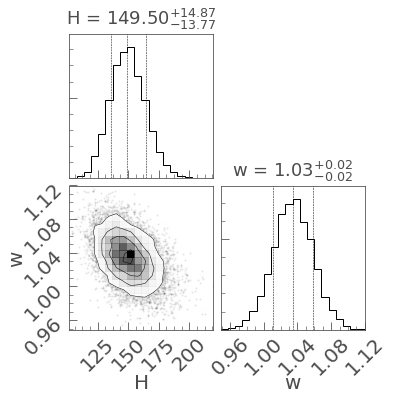

In [92]:
labels=['vsini','nus']
chain = np.array([fit[labels[0]], fit[labels[1]]])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

for idx in range(len(fit['H'].T)):
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx]])
    corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [93]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
nus = np.median(fit['nus'])
for mode in range(len(modeids)):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[mode])
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, modelocs[mode], i, H, w, nus)
fitlocs = np.median(fit['locs'],axis=0)

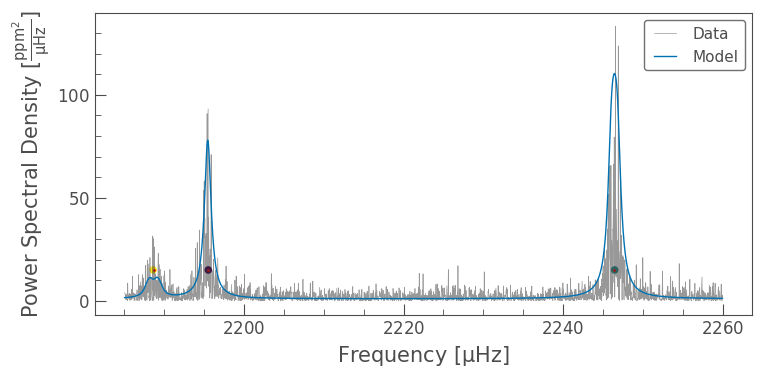

In [94]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
plt.scatter(fitlocs, [15]*len(fitlocs),c=modeids,s=20)
plt.scatter(modelocs, [15]*len(modelocs),c='r')
plt.plot(f, model, linewidth=1, label='Model')
plt.legend()